
<img src="Jeopardy.jpg" width=600 height=60o />

## Context and References

Dataset retrieved from: https://www.kaggle.com/datasets/tunguz/200000-jeopardy-questions?resource=download

#### Context
This is a dataset of 200,000+ Jeopardy! questions and answers. The dataset was constructed with show data from 12-31-2004 to 5-11-2006. Columns relevant to this project will be features question and answer.

#### Attributes
| Column     |Non-Null Count   |Dtype| 
| :-         | -:              | :-: |
|Show Number |216930 non-null  |int64 | 
|Air Date    |216930 non-null  |object|
|Round       |216930 non-null  |object|
|Category    |216930 non-null  |object|
|Value       |216930 non-null  |object|
|Question    |216930 non-null  |object|
|Answer      |216928 non-null  |object|


#### Obective
The goal of this project is to explore, clean, and modify the Jeopardy dataset to construct a simple chatbot based on questions and answers present in the dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import ast 
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [2]:
df_jep = pd.read_csv('JEOPARDY_CSV.csv/JEOPARDY_CSV.csv')

In [3]:
df_jep.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams


In [4]:
df_jep.tail()

,Show Number,Air Date,Round,Category,Value,Question,Answer
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 riddles posed by the heroine,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,"In North America this term is properly applied to only 4 species that are crested, including the tufted",a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up, the barber shaves another customer--then flays him alive!",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona is my land, my home, my father's land, to which I now ask to... return""",Geronimo
216929,4999,2006-05-11,Final Jeopardy!,HISTORIC NAMES,None,A silent movie title includes the last name of this 18th c. statesman & favorite of Catherine the Great,Grigori Alexandrovich Potemkin


In [5]:
df_jep.shape

(216930, 7)

In [6]:
df_jep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       216930 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [7]:
df_jep.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

### Data cleaning to remove extra spaces in column names

In [8]:
df_jep.columns = df_jep.columns.str.replace(' ', '')

### Data cleaning to remove URL text contained in some column values

In [9]:
df_jep['Question'] = df_jep['Question'].str.replace('(.<a[^>]*[^>]*>)((?!<\/a>))','')

### Remove quotes from strings in columns

In [10]:
#df_jep['Question'] = df_jep['Question'].str. replace(r,'')
df_jep['Question'] = df_jep['Question'].map(lambda x: re.sub(r'("")','',x))

In [11]:
#df_jep['Answer'] = df_jep['Answer'].str. replace('"','')

<AxesSubplot:>

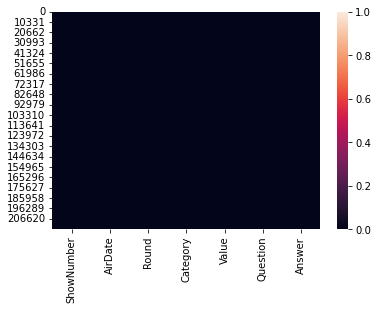

In [12]:
sns.heatmap(df_jep.isnull())

In [13]:
df_jep['Question'][216898]

"Sarah of the Clue Crew reports from in front of a statue in West Point, NY.</a>) West Point cadets struggling academically come to spinthese</a> on General Sedwig's spurs for better luck"

In [14]:
df_jep['Category'].value_counts()


BEFORE & AFTER        547
SCIENCE               519
LITERATURE            496
AMERICAN HISTORY      418
POTPOURRI             401
                     ... 
1999 TELEVISION         1
WORDS IN PHYSICS        1
LITERATURE & MUSIC      1
'90s NOTABLES           1
CELEBRITY NAMES         1
Name: Category, Length: 27995, dtype: int64

In [15]:
n = df_jep['Category'].nunique()
print("Number of unique values in the Categories column: ", n)

Number of unique values in the Categories column:  27995


### Construction of a list to hold question and answer values

In [16]:
#questions = list(df_jep['Question'])
#answers = list(df_jep['Answer'])

answers = list(df_jep['Question'].str.lower())
questions = list(df_jep['Answer'].str.lower())

In [17]:
DF_jep = pd.DataFrame(answers,questions)

In [18]:
DF_jep.head(20)

,0
copernicus,"for the last 8 years of his life, galileo was under house arrest for espousing this man's theory"
jim thorpe,"no. 2: 1912 olympian; football star at carlisle indian school; 6 mlb seasons with the reds, giants & braves"
arizona,"the city of yuma in this state has a record average of 4,055 hours of sunshine each year"
mcdonald's,"in 1963, live on ""the art linkletter show"", this company served its billionth burger"
john adams,"signer of the dec. of indep., framer of the constitution of mass., second president of the united states"
the ant,"in the title of an aesop fable, this insect shared billing with a grasshopper"
the appian way,"built in 312 b.c. to link rome & the south of italy, it's still in use today"
michael jordan,"no. 8: 30 steals for the birmingham barons; 2,306 steals for the bulls"
washington,"in the winter of 1971-72, a record 1,122 inches of snow fell at rainier paradise ranger station in this state"
crate & barrel,this housewares store was named for the packaging its merchandise came in & was first displayed on


In [19]:
DF_jep.shape

(216930, 1)

### Tokenize the text and convert data in matrix format

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(answers)

In [21]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vec)

In [22]:
tfidf

TfidfTransformer()

In [23]:
X_tfidf

<216930x89799 sparse matrix of type '<class 'numpy.float64'>'
	with 1692108 stored elements in Compressed Sparse Row format>

In [24]:
def conversation(im):
    global tfidf, questions, answers, X_tfidf
    Y_vec = vectorizer.transform(im)
    Y_tfidf = tfidf.fit_transform(Y_vec)
    cos_sim = np.rad2deg(np.arccos(max(cosine_similarity(Y_tfidf, X_tfidf)[0])))
    if cos_sim > 60 :
        return "sorry, I did not quite understand that"
    else:
        return questions[np.argmax(cosine_similarity(Y_tfidf, X_tfidf)[0])]

In [25]:
def main():
    usr = input("Hello my name is Alex Trebek, What is your name: ")
    print("Alex: Hi, welcome to JEOPARDY, what would you like to know?")
    while True:
        im = input("{}: ".format(usr))
        if im.lower() == 'bye':
            print("Alex: bye!")
            break
        else:
            print("Alex: "+conversation([im]))

In [26]:
main()

Hello my name is Alex Trebek, What is your name: Brian
Alex: Hi, welcome to JEOPARDY, what would you like to know?
Brian: Jim Brown played for
Alex: cleveland browns
Brian: What is MI
Alex: michigan
Brian: Barack Obama from
Alex: illinois
Brian: pikachu
Alex: pokémon
Brian: Justin Timberlake
Alex: 'n sync
Brian: Donald Trump
Alex: the apprentice
Brian: Who is donald trump
Alex: the apprentice
Brian: The apprentice
Alex: the sorcerer's apprentice
Brian: What is the apprentice
Alex: the sorcerer's apprentice
Brian: deep learning
Alex: dangerous thing
Brian: machine learning
Alex: florence
Brian: Linkin park
Alex: the '90s
Brian: tocos
Alex: sorry, I did not quite understand that
Brian: tacos
Alex: sorry, I did not quite understand that
Brian: copernicus
Alex: bologna
Brian: for the last 8 years of his life, galileo was under house arrest for espousing this man's theory
Alex: copernicus
Brian: bye
Alex: bye!


# Summary and Conclusion

- Overall the dataset contained a good level of content on various categories contained in different records but finding more relationship between subjects and answers would be an improvement  
- With some additional cleaning and advanced techniques I would like to have the Chatbot find all references in the dataset related to the subject to provide the most acurate answer
- Also addressing follow up questions would be nice as the current implementation is producing answers based on the first hit
- Applying more NLP techniques should be applied to provide better responses